# Clusters

This notebook goes through some features implemented in lenstronomy that might be useful for cluster modeling.
The feature list is not complete and it is also work in progress to provide a more complete library of tools to perform cluster lens modeling.

We also refer to [lenstruction](https://github.com/ylilan/lenstruction), a wrapper around lenstronomy to perform source reconstruction in a cluster environment.

We refer to the lenstronomy starting guide and other notebooks for the general design and many options and applications that can also be relevant for applications on the cluster scale.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Utilizing interpolated deflection maps

lenstronomy allows the user to import deflection maps on a grid level into the LensModel class and then can perform different lensing tasks with such an interpolated map.

We will demonstrate this by first generating a deflection angle map from analytical profiles and then generate an interpolated version.


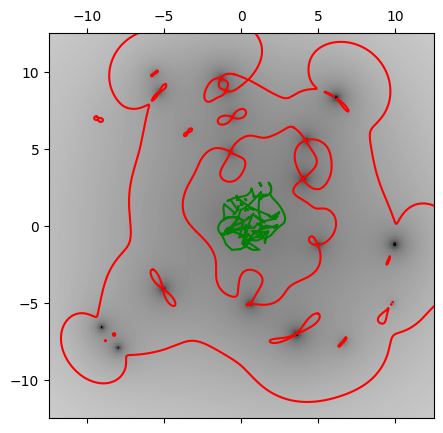

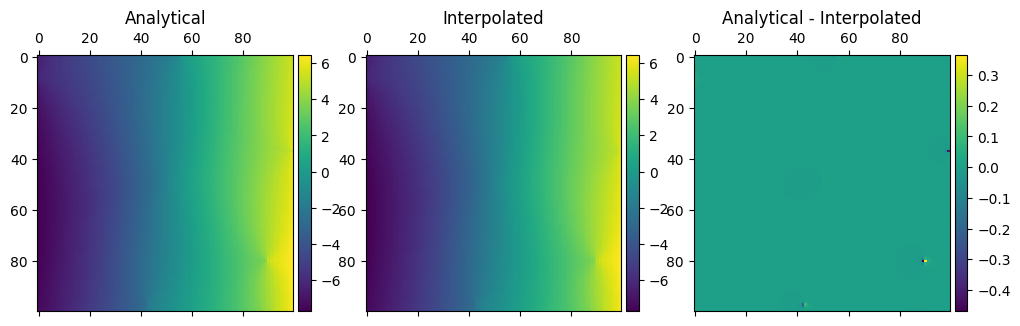

In [2]:
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Util import util


from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)
lens_cosmo = LensCosmo(z_lens=0.5, z_source=1.5, cosmo=cosmo)
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=10**14, c=6)

lens_model_analytical = LensModel(lens_model_list=['NFW_ELLIPSE_CSE'] + ['SIS'] * 20)
kwargs_lens_analytical = [{'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
for i in range(20):
    kwargs_lens_analytical.append({'theta_E': np.random.uniform(0, 1), 
                                   'center_x': np.random.uniform(-10, 10),
                                   'center_y': np.random.uniform(-10, 10)})

    
from lenstronomy.Plots import lens_plot
f, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(ax, lensModel=lens_model_analytical, kwargs_lens=kwargs_lens_analytical, 
                          numPix=500, deltaPix=0.05,
                          point_source=False, with_caustics=True, fast_caustic=True, coord_inverse=False)
plt.show()
    
# make a grid
numPix = 501
deltaPix = 0.1
x_grid_interp, y_grid_interp = util.make_grid(numPix, deltaPix)

# compute analytical defection field on a grid
f_ = lens_model_analytical.potential(x_grid_interp, y_grid_interp, kwargs=kwargs_lens_analytical)
f_x, f_y = lens_model_analytical.alpha(x_grid_interp, y_grid_interp, kwargs=kwargs_lens_analytical)
f_xx, f_xy, f_yx, f_yy = lens_model_analytical.hessian(x_grid_interp, y_grid_interp, kwargs=kwargs_lens_analytical)



# generate an interpolation class

lens_model_interp = LensModel(lens_model_list=['INTERPOL'])

# we need the rectangular axes for the interpolation
x_axes, y_axes = util.get_axes(x_grid_interp, y_grid_interp)

# Note: to evaluate deflection fields, only the f_x and f_y statements are needed in addition to the grid statements

kwargs_interp = [{'grid_interp_x': x_axes, 'grid_interp_y': y_axes, 
                  'f_': util.array2image(f_), 
                  'f_x': util.array2image(f_x), 
                  'f_y': util.array2image(f_y), 
                  'f_xx': util.array2image(f_xx), 
                  'f_yy': util.array2image(f_yy), 
                  'f_xy': util.array2image(f_xy)}
                ]

# and now we compare the deflection field on a different grid

x_grid, y_grid = util.make_grid(numPix=100, deltapix=0.1)
f_x_a, f_y_a = lens_model_analytical.alpha(x_grid, y_grid, kwargs_lens_analytical)
f_x_i, f_y_i = lens_model_interp.alpha(x_grid, y_grid, kwargs_interp)


fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 6))

im = ax0.matshow(util.array2image(f_x_a))
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
ax0.set_title('Analytical')


im = ax1.matshow(util.array2image(f_x_i))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
ax1.set_title('Interpolated')

im = ax2.matshow(util.array2image(f_x_a - f_x_i))
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
ax2.set_title('Analytical - Interpolated')

plt.show()


##  A variety of lens mass profiles

lenstronomy supports a variety of lens models, multi-plane ray tracing, solving the lens equation etc.
Among the deflector profiles is a PIEMD (currently with ellipticity in the potential), generalized NFW profiles and many more.


In [3]:
# the Pseud0-Jaffe profile, also known as PIEMD
lens_model = LensModel(lens_model_list=['PJAFFE_ELLIPSE'])
kwargs_lens = [{'sigma0': 2, 'Ra': 0.5, 'Rs': 3, 'e1': 0.1, 'e2':-0.1, 'center_x': 0, 'center_y': 0}]

## Model fitting

lenstronomy has the ability to fit image positions. A more detailed notebook about features for catalogue modeling can be found [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/LensModeling/modelling_of_catalogue_data.ipynb).

In this notebook, we will but several sources at different redshift, solve the lens equation to predict their image positions, and then fit a lens model with backwards ray-tracing.


In [4]:
# TODO this section is incomplete and needs work in the source code to allow for 
# joint fitting of point sources at different redshifts